In [1]:
%load_ext autoreload
%autoreload

# Setup Paths

In [2]:
import os
import pyrootutils
root = pyrootutils.setup_root(
    search_from='.',
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)
hydra_cfg_path = root / "image_classification_problems" / "configs"
os.chdir(root / "image_classification_problems")

In [14]:
import hydra
from hydra import compose, initialize

from pathlib import Path
import numpy as np
import torch
from core.grads import tree_to_device
from core.tracer import KNN, KNNGD, KNNGN
from sklearn.neighbors import KNeighborsClassifier
from image_classification_problems.train import Model
from image_classification_problems.datamodule import DMStage
from tqdm import tqdm

# Config  

In [4]:
'..' / hydra_cfg_path.relative_to(root)
with initialize(version_base=None, config_path= '../configs'):
    cfg = compose(config_name="tracing", return_hydra_config=True, overrides=["datamodule=cifar10"])

In [5]:
device = 'cuda:0'

# Load Data and Model

In [7]:
from datamodule import Cifar10DM

In [8]:
checkpoint = torch.load("outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=11_val_acc=0.8318.ckpt")
datamodule_hparams = checkpoint["datamodule_hyper_parameters"] 
del datamodule_hparams['data_root']

In [9]:
dm = Cifar10DM(data_root=os.environ['PYTORCH_DATASET_ROOT'], **datamodule_hparams)
dm.prepare_data()
dm.setup("tracing")

Files already downloaded and verified
Files already downloaded and verified


In [10]:
net = hydra.utils.instantiate(cfg.net, num_classes=dm.num_classes)
lit_model = Model.load_from_checkpoint(
    checkpoint_path="outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=01_val_acc=0.6210.ckpt",
    net=net,
    num_classes=dm.num_classes,
    learning_rate=1e-3,
)
net = lit_model.net
lit_model.eval()
lit_model.to(device);

In [11]:
train_loader = dm.train_dataloader(shuffle=False)

## KNN Indexs

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [71]:
features = []
labels = []
with torch.no_grad():
    for batch in train_loader:
        x, y = tree_to_device(batch, device)
        features.append(lit_model.net.feature_forward(x).cpu())
        labels.append(y.cpu())
features = torch.concat(features).numpy()
labels = torch.concat(labels).numpy()

In [72]:
neigh = KNeighborsClassifier(n_neighbors=1000, metric='minkowski', algorithm='kd_tree', n_jobs=-1)
neigh.fit(features, labels)
neibor_inds = []
for i in tqdm(range(0, features.shape[0], 64)):
    neibor_inds.append(neigh.kneighbors(features[i:i+64, :], n_neighbors=1000, return_distance=False))
neibor_inds = np.concatenate(neibor_inds, axis=0)
neibor_inds = torch.tensor(neibor_inds)

100%|██████████| 782/782 [01:06<00:00, 11.79it/s]


In [38]:
np.savez_compressed('outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/last.npz', neibor_inds.numpy())

100%|██████████| 782/782 [00:52<00:00, 14.95it/s]


In [22]:
neibor_inds = np.load('outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/last.npz')['arr_0']

## Tracing

In [20]:
from core.grads import RuntimeGradientExtractor
from core.tracer import GradientNormalize as GN, GradientCosin as GC, GradientBasedTracer as GD
from image_classification_problems.convert_result import process_results
import torch.nn.functional as F
import pandas as pd

In [73]:
train_loader = dm.train_dataloader(shuffle=False)
knn_tracer = KNN(net=lit_model.net, k=1000, neighbor_matrices=neibor_inds[:, :100])
label_from_batch = lambda b: b[1]
scores = knn_tracer._trace_dataloader(train_loader, label_from_batch=label_from_batch)
value, inds = scores.sort(descending=True)
top_sizes = (torch.tensor([0.05, 0.1, 0.15,0.2])*50000).tolist()
all_results = []
for top_size in top_sizes:
    top_size = int(top_size)
    print(top_size)
    all_results.append(torch.isin(inds[:top_size], dm.flipped_idx).sum().item() / top_size)
print(all_results)

2500
5000
7500
10000
[0.9004, 0.8704, 0.8262666666666667, 0.7573]


outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=00_val_acc=0.4964.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=01_val_acc=0.6210.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=02_val_acc=0.6522.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=03_val_acc=0.7031.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=04_val_acc=0.7351.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=05_val_acc=0.7555.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=06_val_acc=0.7830.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=07_val_acc=0.8118.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=08_val_acc=0.8136.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=09_val_acc=0.8179.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints/epoch=10_val_acc=0.8112.ckpt
outputs/train/cifar10_wrn/2023-01-04_09-47-

In [22]:
dm.hparams.train_batch_size = 256
train_loader = dm.train_dataloader(shuffle=False)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
ckpts = list(Path('outputs/train/cifar10_wrn/2023-01-04_09-47-30/checkpoints').glob("epoch=*"))
ckpts.sort()
df = pd.DataFrame(columns=("epoch", "top5", "top10", "top15", "top20"))
with torch.no_grad():
    for e, ckpt in enumerate(ckpts):
        losses = []
        for batch in train_loader:
            batch = tree_to_device(batch, device)
            images, targets = batch
            logits = lit_model.net(images)
            losses.append(criterion(logits, targets).cpu())
        losses = torch.cat(losses)
        value, inds = losses.sort(descending=True)
        top_sizes = (torch.tensor([0.05, 0.1, 0.15,0.2])*50000).tolist()
        all_results = []
        for top_size in top_sizes:
            top_size = int(top_size)
            all_results.append((torch.isin(inds[:top_size], dm.flipped_idx).sum().item() / top_size)*100)
        print(all_results)
        all_results.insert(0, e)
        df.loc[len(df.index)] = all_results

[98.32, 93.76, 85.32, 75.05]
[98.2, 93.96, 85.65333333333334, 74.89]
[98.2, 93.89999999999999, 85.38666666666667, 75.02]
[98.11999999999999, 93.82000000000001, 85.44, 75.12]
[98.48, 93.88, 85.58666666666667, 75.09]
[98.16, 93.72, 85.54666666666667, 75.11]
[98.28, 94.12, 85.30666666666666, 74.8]
[98.48, 94.12, 85.69333333333333, 75.18]
[98.16, 93.94, 85.44, 75.07000000000001]
[98.28, 93.96, 85.69333333333333, 75.19]
[98.28, 94.04, 85.54666666666667, 75.01]
[98.08, 93.84, 85.52, 75.17]
[98.08, 93.86, 85.37333333333333, 75.1]
[98.16, 94.04, 85.62666666666667, 75.2]
[98.2, 94.0, 85.53333333333333, 74.88]
[98.36, 93.72, 85.33333333333334, 74.95]
[98.16, 93.7, 85.29333333333334, 74.92999999999999]
[98.16, 94.24, 85.56, 75.17]
[98.32, 93.84, 85.24000000000001, 75.02]
[98.08, 94.04, 85.33333333333334, 74.92]


In [31]:
df

,epoch,top5,top10,top15,top20
0,0.0,98.32,93.76,85.320000,75.05
1,1.0,98.20,93.96,85.653333,74.89
2,2.0,98.20,93.90,85.386667,75.02
3,3.0,98.12,93.82,85.440000,75.12
4,4.0,98.48,93.88,85.586667,75.09
5,5.0,98.16,93.72,85.546667,75.11
6,6.0,98.28,94.12,85.306667,74.80
7,7.0,98.48,94.12,85.693333,75.18
8,8.0,98.16,93.94,85.440000,75.07
9,9.0,98.28,93.96,85.693333,75.19


(50.0, 100.0)

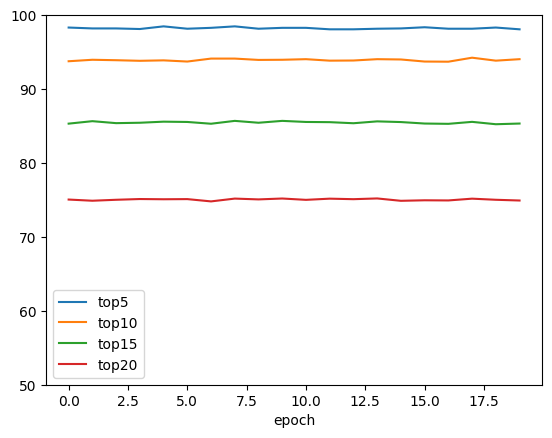

In [30]:
ax = df.plot(x="epoch", y="top5")
ax = df.plot(x="epoch", y="top10", ax=ax)
ax = df.plot(x="epoch", y="top15", ax=ax)
ax = df.plot(x="epoch", y="top20", ax=ax)
ax.set_ylim(50, 100)

In [63]:
def loss_fn(pred_fn, Z):
        X, Y = Z
        preds = pred_fn(X)
        return F.cross_entropy(preds, Y)
grad_extractor = RuntimeGradientExtractor(
                                lit_model, 
                                split_params=lambda params: (params[:-2], params[-2:]), 
                                merge_params=lambda w1, w2: w1 + w2,
                                loss_fn=loss_fn,
                                input_sample=next(iter(train_loader)))

[torch.Size([1, 3, 32, 32]), torch.Size([1])]
[torch.Size([1, 3, 32, 32]), torch.Size([1])]


In [65]:
train_grad_norms = []
dm.hparams.train_batch_size=128
train_loader = dm.train_dataloader(shuffle=False)
for b, grads in grad_extractor.get_iter(train_loader):
    train_grad_norms.append(grads.norm(dim=1))
train_grad_norms = torch.cat(train_grad_norms).cpu()
value, inds = train_grad_norms.sort(descending=True)
top_sizes = (torch.tensor([0.05, 0.1, 0.15,0.2])*50000).tolist()
all_results = []
for top_size in top_sizes:
    top_size = int(top_size)
    print(top_size)
    all_results.append(torch.isin(inds[:top_size], dm.flipped_idx).sum().item() / top_size)
print(all_results)

2500
5000
7500
10000
[0.946, 0.926, 0.8846666666666667, 0.8334]


In [67]:
ref_targets = torch.cat([b[1] for b in dm.test_dataloader()])
is_class = ref_targets[:, None] == torch.arange(10)
is_class = is_class.T
print(f'Number of element in each class: {is_class.sum(axis=1).tolist()}')

Number of element in each class: [44, 60, 50, 51, 48, 51, 49, 48, 48, 51]


In [68]:
gn_tracer = GD(grad_extractor=grad_extractor)
scores = gn_tracer.trace_dataloader(train_loader=train_loader, test_loader=dm.test_dataloader())
scores = scores.cpu()
process_results(scores, ref_targets, dm.flipped_idx, 10, True)

Allocating a matrix of size: (500, 50000)


Seting up Tracer: 4it [00:00, 10.28it/s]
Tracing: 100%|██████████| 391/391 [00:11<00:00, 32.93it/s]


Number of element in each class: tensor([44, 60, 50, 51, 48, 51, 49, 48, 48, 51])
torch.Size([10, 50000])


([90.47999978065491, 83.45999717712402, 74.10666942596436, 63.749998807907104],
 [80.08000254631042, 78.47999930381775, 77.99999713897705, 73.82000088691711])

In [66]:
gn_tracer = GN(grad_extractor=grad_extractor)
scores = gn_tracer.trace_dataloader(train_loader=train_loader, test_loader=dm.test_dataloader())
scores = scores.cpu()
process_results(scores, ref_targets, dm.flipped_idx, 10, True)

Allocating a matrix of size: (500, 50000)


Seting up Tracer: 4it [00:00,  9.63it/s]
Tracing: 100%|██████████| 782/782 [00:16<00:00, 46.25it/s]


Number of element in each class: tensor([44, 60, 50, 51, 48, 51, 49, 48, 48, 51])
torch.Size([10, 50000])


([100.0, 99.59999918937683, 99.29333329200745, 98.86999726295471],
 [98.36000204086304, 98.51999878883362, 98.28000068664551, 97.75999784469604])

In [74]:
gn_tracer = GC(grad_extractor=grad_extractor)
scores = gn_tracer.trace_dataloader(train_loader=train_loader, test_loader=dm.test_dataloader())
scores = scores.cpu()
ref_targets = torch.cat([b[1] for b in dm.test_dataloader()])
process_results(scores, ref_targets, dm.flipped_idx, 10, True)

Allocating a matrix of size: (500, 50000)


Seting up Tracer: 4it [00:00,  9.69it/s]
Tracing: 100%|██████████| 782/782 [00:17<00:00, 44.75it/s]


Number of element in each class: tensor([44, 60, 50, 51, 48, 51, 49, 48, 48, 51])
torch.Size([10, 50000])


([57.56000280380249,
  38.999998569488525,
  29.240000247955322,
  23.240000009536743],
 [40.32000005245209, 32.46000111103058, 24.959999322891235, 20.20000070333481])

In [72]:
knn_tracer = KNNGD(grad_extractor=grad_extractor, neighbor_matrices=neibor_inds[:, :1000])
scores = knn_tracer._trace_dataloader(train_loader=train_loader, test_loader=None)
scores = scores[0].cpu()
value, inds = scores.sort(descending=False)
top_sizes = (torch.tensor([0.05, 0.1, 0.15,0.2])*50000).tolist()
all_results = []
for top_size in top_sizes:
    top_size = int(top_size)
    print(top_size)
    all_results.append(torch.isin(inds[:top_size], dm.flipped_idx).sum().item() / top_size)
print(all_results)

Seting up Tracer: 782it [00:17, 45.53it/s]


2500
5000
7500
10000
[0.6092, 0.4324, 0.318, 0.2405]


In [73]:
knn_tracer = KNNGN(grad_extractor=grad_extractor, neighbor_matrices=neibor_inds[:, :1000])
scores = knn_tracer._trace_dataloader(train_loader=train_loader, test_loader=None)
scores = scores[0].cpu()
value, inds = scores.sort(descending=False)
top_sizes = (torch.tensor([0.05, 0.1, 0.15,0.2])*50000).tolist()
all_results = []
for top_size in top_sizes:
    top_size = int(top_size)
    print(top_size)
    all_results.append(torch.isin(inds[:top_size], dm.flipped_idx).sum().item() / top_size)
print(all_results)

Seting up Tracer: 782it [00:17, 45.36it/s]


2500
5000
7500
10000
[0.6316, 0.4284, 0.31866666666666665, 0.2408]


In [51]:
dm = hydra.utils.instantiate(cfg.datamodule, data_root=os.environ['PYTORCH_DATASET_ROOT'], flip_percent=0.5)
dm.prepare_data()
dm.setup("tracing")

Files already downloaded and verified
Files already downloaded and verified


In [42]:
import matplotlib.pyplot as plt

In [55]:
plt.hist(train_grd_norms.cpu(), bins=100)

NameError: name 'plt' is not defined